## Treinamento do Modelo de Classificação - Clima de Brasília em 2024

O objetivo é classificar se choveu ou não em Brasília, utilizando dados horários com características climáticas, e o **recall** será a métrica principal foco durante o treinamento dos modelos para garantir que a maior quantidade possível de eventos de chuva reais seja detectada.

Essa escolha foi pensada porque, em problemas de desbalanceamento de classes como esse, priorizar o recall ajuda a reduzir os falsos negativos (ou seja, casos reais de chuva que o modelo deixaria de prever), algo que é crucial em aplicações como previsão meteorológica.

In [ ]:
# Importando bibliotecas
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

# Otimização de hiperperâmetros
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

# Métricas de avaliação
from sklearn.metrics import (f1_score, precision_score,
                             recall_score, roc_auc_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay)

# Ignorar avisos de alerta
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Definindo tema seaborn
sns.set_theme()

# Configuração de log
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s [%(levelname)s] ➧ %(message)s',
                    datefmt='%d/%m/%Y | %H:%M:%S')

In [4]:
df = pd.read_csv("../data/INMET_DF_processado.csv", index_col="data", parse_dates=True)
print(f"Quantidade de linhas: {df.shape[0]}")
print(f"Quantidade de colunas: {df.shape[1]}")

Quantidade de linhas: 8732
Quantidade de colunas: 40


In [5]:
df.columns

Index(['precipitacao total', 'pressao atmos nv estacao', 'pressao atmos max',
       'pressao atmos min', 'radiacao', 'temp ar', 'temp pronto orvalho',
       'temp max', 'temp min', 'temp orvalho max', 'temp orvalho min',
       'umidade max', 'umidade min', 'umidade relativa ar', 'vento direcao',
       'vento rajada max', 'vento velocidade', 'dia_do_mes', 'semana_do_ano',
       'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos', 'hora_num',
       'hora_sin', 'hora_cos', 'umidade_lag_1h', 'umidade_lag_3h',
       'pressao_lag_1h', 'pressao_tendencia_1h', 'umidade_media_3h',
       'umidade_std_3h', 'umidade_media_6h', 'umidade_std_6h',
       'umidade_media_12h', 'umidade_std_12h', 'umidade_media_24h',
       'umidade_std_24h', 'chuva_acumulada_24h', 'choveu'],
      dtype='object')

Analisando as features, podemos notar que ainda está presente a coluna `hora_num`. Como foi criada as features cíclicas dessas duas, elas se tornam redundantes para o modelo, sendo a melhor decisão remover durante o treinamento. Outra feature importante, é a `precipitacao total`. Já que o objetivo é classificar se choveu ou não, usando a coluna `choveu` como o alvo `y`, a `precipitacao total` é como um gabarito sendo vazado, o que geraria um *data leakage*. Deste modo, será removida também do conjunto de treinamento.

Para dividir os dados, será utilizado a função `TimeSeriesSplit()` por ser apropriada para dados temporais. O objetivo será:

- Dividir os dados em 3 grupos chamados de `Fold`. 

- Cada grupo terá um conjunto de treino e teste.

- O tamanho de teste será definido para `720`. 

**Obs.:** Cada amostra possui uma granularidade horária. Definir `test_size=1` é o mesmo que dizer para pegar a última 1 hora para testes dentro do Fold. Ao definir `test_size=720` garante 720 horas, equivalente aos últimos **30 dias** para testes.

In [15]:
X, y = df.drop(columns=["precipitacao total", "choveu", "hora_num"]), df["choveu"]

tscv = TimeSeriesSplit(n_splits=3, test_size=720)
for i, (train_index, test_index) in enumerate(tscv.split(X)):   
    print(f"Fold {i+1}:")
    print(f"  - Treino: índices: [{train_index[0]}, ..., {train_index[-1]}]")
    print(f"  - Teste:  índices: [{test_index[0]}, ..., {test_index[-1]}]\n")

Fold 1:
  - Treino: índices: [0, ..., 6571]
  - Teste:  índices: [6572, ..., 7291]

Fold 2:
  - Treino: índices: [0, ..., 7291]
  - Teste:  índices: [7292, ..., 8011]

Fold 3:
  - Treino: índices: [0, ..., 8011]
  - Teste:  índices: [8012, ..., 8731]



In [7]:
y.value_counts()

choveu
0    8132
1     600
Name: count, dtype: int64

Prever chuva é um grande problema com classes desbalanceadas. No conjunto de teste, há uma quantidade muito maior de horas em que não choveu (classe 0) em comparação às horas em que choveu (classe 1).

Isso significa que um modelo simples poderia obter uma alta acurácia apenas prevendo sempre a classe majoritária ("não choveu"), sem realmente aprender nada útil. Portanto, é fundamental aplicar técnicas adequadas de avaliação e escolher métricas que reflitam melhor o desempenho nesse cenário.

In [16]:
pipelines = {
    'Regressão Logística': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            random_state=42,
        ))
    ]),

    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(
            random_state=42
        ))
    ]),

    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        ))
    ]),

    'LightGBM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LGBMClassifier(
            objective='binary',
            random_state=42,
            verbose=-1
        ))
    ])
}

**Modelos Utilizados**

➥ Regressão Logística (Logistic Regression)

Esse modelo será ideal para estabelecer um baseline, ou seja, um ponto de referência para comparar modelos mais sofisticados, pois é um modelo linear e pode não capturar relações mais complexas e não-lineares presentes nos fenômenos climáticos.

➥ Random Forest Classifier

Combina várias árvores de decisão de forma conjunta, tirando uma média das previsões. Essa abordagem reduz a variância e melhora a robustez do modelo. Com isso, possui uma maior resistência ao overfitting e boa capacidade de capturar interações complexas entre variáveis.

➥ Gradient Boosting Machines (XGBoost e LightGBM)

Modelos de boosting, como XGBoost e LightGBM, constroem árvores de forma sequencial, onde cada nova árvore busca corrigir os erros da anterior. No entanto, eles possuem uma maior complexidade no processo de tuning de hiperparâmetros.

In [17]:
# Espaço de busca dos hiperparâmetros
param_grids = {
    'Regressão Logística': {
        'scaler': [StandardScaler(), RobustScaler()],
        'classifier__C': loguniform(1e-3, 1e2),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__class_weight': [None, 'balanced']
    },

    'Random Forest': {
        'scaler': [StandardScaler(), RobustScaler()],
        'classifier__n_estimators': randint(100, 500),
        'classifier__max_depth': randint(3, 20),
        'classifier__min_samples_split': randint(2, 10),
        'classifier__min_samples_leaf': randint(1, 5),
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__criterion': ['gini', 'entropy']
    },

    'XGBoost': {
        'scaler': [StandardScaler(), RobustScaler()],
        'classifier__n_estimators': randint(100, 500),
        'classifier__max_depth': randint(3, 15),
        'classifier__learning_rate': loguniform(0.01, 0.3),
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__gamma': loguniform(1e-8, 1.0),
        'classifier__reg_alpha': loguniform(1e-8, 1.0),
        'classifier__reg_lambda': loguniform(1e-8, 1.0),
        'classifier__scale_pos_weight': [1]
    },
    
    'LightGBM': {
        'scaler': [StandardScaler(), RobustScaler()],
        'classifier__n_estimators': randint(100, 500),
        'classifier__max_depth': randint(-1, 15),
        'classifier__num_leaves': randint(20, 150),
        'classifier__learning_rate': loguniform(0.01, 0.3),
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__min_child_samples': randint(5, 50),
        'classifier__reg_alpha': loguniform(1e-8, 1.0),
        'classifier__reg_lambda': loguniform(1e-8, 1.0),
        'classifier__scale_pos_weight': [1]
    }
}

Para cada modelo, foi definido um conjunto de **hiperparâmetros candidatos** que serão explorados durante a busca aleatória `RandomizedSearchCV`.
O objetivo é equilibrar a diversidade de combinações para encontrar boas soluções e a viabilidade computacional, para evitar um grid muito extenso e custoso.


**Regressão Logística**

- O foco é variar parâmetros que controlam **regularização** e **robustez** ao desbalanceamento.


**Random Forest**

- Os hiperparâmetros controlam o **número de árvores**, a **profundidade** e a **diversidade** das arvores.


**XGBoost**

- O XGBoost é um método de boosting baseado em árvores. O ajuste foca em parâmetros que controlam **complexidade das árvores**, **aprendizado incremental** e **regularização**.

**LightGBM**

- O LightGBM é similar ao XGBoost, mas otimizado para eficiência e uso de histogramas. Seus hiperparâmetros também controlam **profundidade**, **número de folhas** e **regularização**.



In [44]:
# armazenar os resultados
results = {}
for name in pipelines.keys():
    results[name] = {'f1': [], 'recall': [], 'precision': [], 'auc': []}

logging.info("Iniciando treinamento e validação de múltiplos modelos...\n")
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"--- FOLD {i+1}/{tscv.get_n_splits()} ---")

    # dividindo os dados a cada fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # atualizando pesos nos modelos gbm (por fold)
    imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
    param_grids['XGBoost']['classifier__scale_pos_weight'] = [1, imbalance_ratio]
    param_grids['LightGBM']['classifier__scale_pos_weight'] = [1, imbalance_ratio]

    # buscando melhores parametros
    for name, pipeline in pipelines.items():
        print(f"⟳ Rodando busca para {name}...")
        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grids[name],
            n_iter=50,
            cv=5,
            scoring='recall',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )

        # treinamento...
        search.fit(X_train, y_train)

        # obtenção de resultados
        best_model = search.best_estimator_
        best_score = search.best_score_
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        # calculando métricas
        results[name]['f1'].append(f1_score(y_test, y_pred))
        results[name]['recall'].append(recall_score(y_test, y_pred))
        results[name]['precision'].append(precision_score(y_test, y_pred))
        results[name]['auc'].append(roc_auc_score(y_test, y_prob))
    print("-" * 50 + "\n", flush=True)

logging.info("Treinamento concluído!")

11/09/2025 | 10:03:20 [INFO] ➧ Iniciando treinamento e validação de múltiplos modelos...



--- FOLD 1/3 ---
⟳ Rodando busca para Regressão Logística...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
⟳ Rodando busca para Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
⟳ Rodando busca para XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
⟳ Rodando busca para LightGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--------------------------------------------------

--- FOLD 2/3 ---
⟳ Rodando busca para Regressão Logística...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
⟳ Rodando busca para Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
⟳ Rodando busca para XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
⟳ Rodando busca para LightGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
--------------------------------------------------

--- FOLD 3/3 ---
⟳ Rodando busca para Regressão Logística...
Fitting 5 f

11/09/2025 | 10:20:34 [INFO] ➧ Treinamento concluído!


**Avaliação de Modelos**

Devido ao desbalanceamento das classes, a acurácia não é uma métrica confiável nesse problema. Serão utilizadas as métricas:

- Recall (sensibilidade): entre todas as ocorrências reais de chuva, ele indica quantas o modelo conseguiu prever (essa métrica foi o foco durante o treinamento). 

- Precision: entre todas as vezes em que o modelo previu chuva, quantas foram corretas. Isso é importante para evitar falsos alarmes.

- F1-Score: média harmônica entre precisão e recall, oferecendo um equilíbrio entre ambas.

- AUC-ROC: mede a capacidade de separação entre classes, avaliando a qualidade geral do modelo em distinguir entre “chuva” e “não chuva”.

In [61]:
final_results = []
for name, metrics in results.items():
    final_results.append({
        "Modelo": name,
        "F1-Score (média)": np.mean(metrics['f1']),
        "F1-Score (std)": np.std(metrics['f1']),
        "Recall (média)": np.mean(metrics['recall']),
        "Recall (std)": np.std(metrics['recall']),
        "Precision (média)": np.mean(metrics['precision']),
        "Precision (std)": np.std(metrics['precision']),
        "AUC (média)": np.mean(metrics['auc']),
        "AUC (std)": np.std(metrics['auc']),
    })

df_results = pd.DataFrame(final_results)
df_results = df_results.round(4)
df_results

,Modelo,F1-Score (média),F1-Score (std),Recall (média),Recall (std),Precision (média),Precision (std),AUC (média),AUC (std)
0,Regressão Logística,0.3680,0.0293,0.9834,0.0150,0.2269,0.0225,0.8838,0.0070
1,Random Forest,0.4655,0.0520,0.8848,0.1100,0.3160,0.0343,0.8697,0.0320
2,XGBoost,0.5662,0.0543,0.8816,0.0385,0.4218,0.0642,0.9272,0.0060
3,LightGBM,0.5987,0.0718,0.6891,0.1013,0.5425,0.1048,0.9181,0.0055


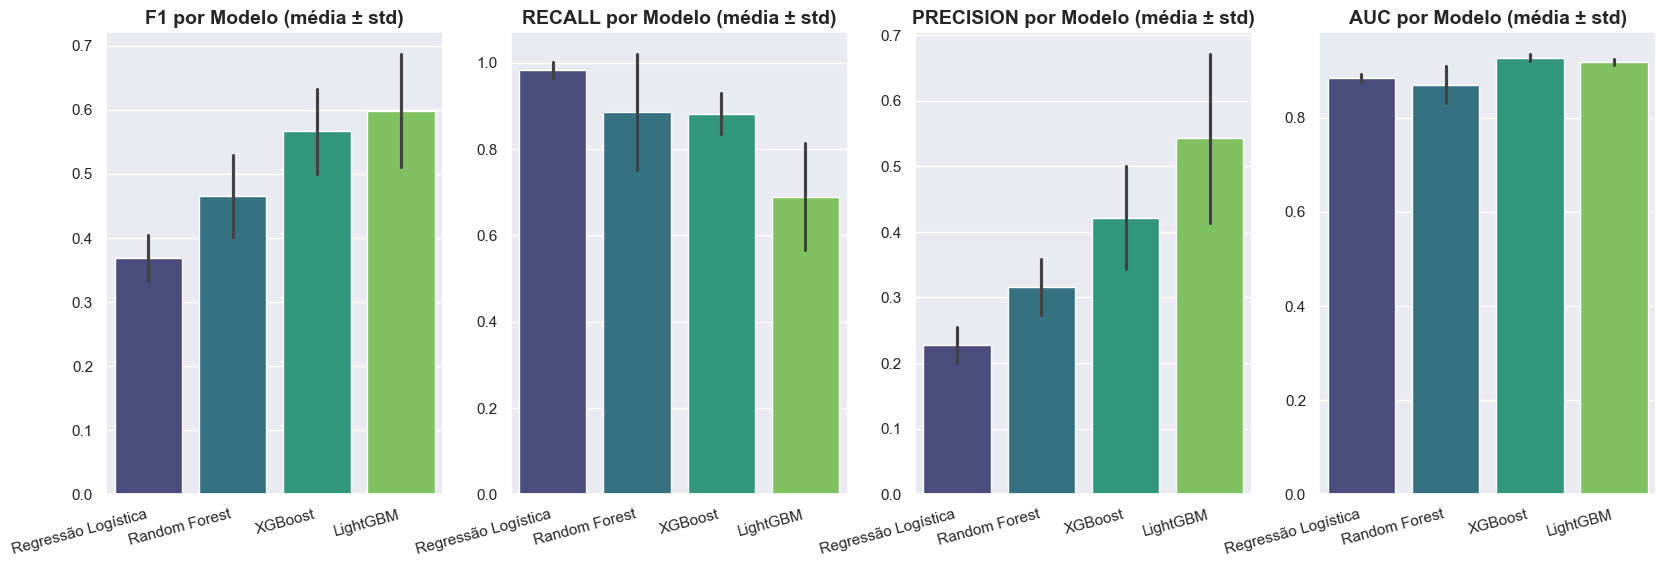

In [ ]:
# Preparando dados em dataframe para plotagem
df_results_gr = pd.DataFrame([
    {"modelo": modelo, "metric": metric, "value": value}
    for modelo, metrics_dict in results.items()
    for metric, values in metrics_dict.items()
    for value in values
])

metrics_to_plot = df_results_gr['metric'].unique()

# Preparando gráficos
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(5*len(metrics_to_plot), 6), sharey=False)

for ax, metric in zip(axes, metrics_to_plot):
    sns.barplot(
        data=df_results_gr[df_results_gr['metric'] == metric],
        x='modelo',
        y='value',
        ci='sd',
        palette='viridis',
        ax=ax
    )
    ax.set_title(f"{metric.upper()} por Modelo (média ± std)", fontsize=14, fontweight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

O XGBoost é o melhor modelo para o problema de previsão de chuva porque entrega o melhor equilíbrio entre todas as métricas principais, especialmente considerando o contexto de classes desbalanceadas e o foco em recall.

Fatores que justificam o XGBoost como melhor modelo:

**F1-Score**

- O XGBoost apresenta um dos maiores valores de F1-score entre os modelos testados, representando o melhor compromisso entre precisão e recall.

- Isso garante que o modelo é eficaz tanto em identificar casos reais de chuva (recall), quanto em evitar muitos falsos alarmes (precisão), proporcionando alertas mais confiáveis.

**Recall**
- O recall do XGBoost é muito alto, quase igual ao Random Forest, e apenas um pouco inferior à Regressão Logística, mantendo o modelo sensível e capaz de detectar a maioria dos eventos reais de chuva.

- Entretanto, ao contrário da Regressão Logística, o XGBoost não sacrifica tanto a precisão para obter esse recall.

**Precisão**
- O XGBoost tem precisão substancialmente maior que Regressão Logística e Random Forest, o que significa menos falsos positivos (menos previsões de chuva quando não chove).

**Maior AUC**
- O modelo apresenta o maior valor de AUC entre todos os modelos, mostrando que separa melhor os casos de chuva e não chuva de forma geral.

- A alta AUC indica robustez, performance consistente e capacidade superior de discriminação entre as classes.

Resumindo, ao comparar os modelos pela média e desvio padrão das métricas (F1, Recall, Precision, AUC), o XGBoost se destaca por manter todas em níveis altos, enquanto outros modelos apresentam lacunas: a Regressão Logística sacrifica precisão; o LightGBM sacrifica recall; o Random Forest não iguala o F1 do XGBoost. Portanto, para o objetivo de prever chuva com mínimo de erros e máxima sensibilidade, o XGBoost é a escolha mais equilibrada e eficaz.


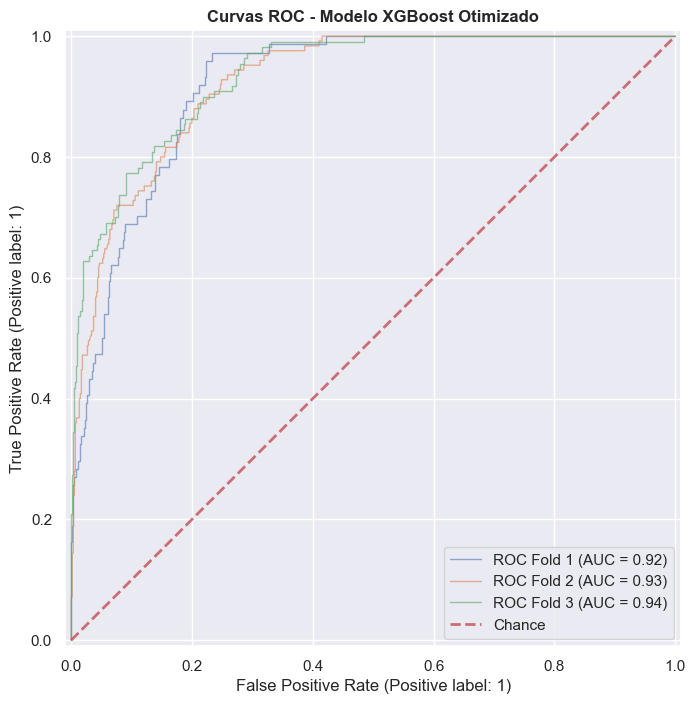

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
aucs = []

# Melhor modelo (XGBoost)
xgb_pipeline = pipelines['XGBoost'] 
xgb_params = param_grids['XGBoost']

# Loop pelos folds
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_params['classifier__scale_pos_weight'] = [1, imbalance_ratio]
    
    search = RandomizedSearchCV(
        estimator=xgb_pipeline,
        param_distributions=xgb_params,
        n_iter=50,
        cv=5,
        scoring='recall',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_optimized_model = search.best_estimator_
    
    # Curva ROC
    viz = RocCurveDisplay.from_estimator(
        best_optimized_model,
        X_test,
        y_test,
        name=f"ROC Fold {i+1}",
        alpha=0.6,
        lw=1,
        ax=ax,
    )
    aucs.append(viz.roc_auc)

# Plot
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.set_title("Curvas ROC - Modelo XGBoost Otimizado", fontweight='bold')
ax.legend(loc="lower right")
plt.show()

A curva ROC exibe o desempenho do modelo XGBoost nos três folds de validação. O eixo y mostra o True Positive Rate (sensibilidade/recall), enquanto o eixo x indica o False Positive Rate (falsos positivos). As três curvas estão bem acima da linha de chance (diagonal vermelha), indicando excelente desempenho. Os valores de AUC para os folds (0.92, 0.93 e 0.94) reforçam que o modelo diferencia muito bem entre os casos de chuva e não chuva em diferentes divisões do tempo, demonstrando alta capacidade discriminativa e estabilidade

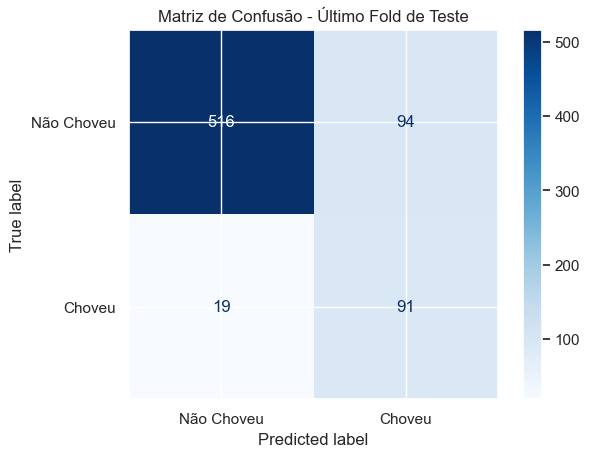

In [ ]:
# Buscando resultado do ultimo fold
y_pred_final = search.predict(X_test)

# Preparando Matriz de Confusaoo
cm = confusion_matrix(y_test, y_pred_final)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Choveu', 'Choveu'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Último Fold de Teste')
plt.show()

A matriz revela os acertos e erros do modelo XGBoost no último fold de teste. Foram obtidos 91 acertos de chuvas (verdadeiros positivos) e 516 acertos de não chuva (verdadeiros negativos). O modelo teve 19 falsos negativos (casos de chuva não previstos) e 94 falsos positivos (previsões de chuva indevidas). Esse resultado indica que o modelo consegue detectar a maioria dos eventos de chuva (alto recall), ao mesmo tempo que mantém um número controlado de falsos positivos, o que é importante em aplicações reais.

In [ ]:
# Buscando melhore estimador
best_pipeline = search.best_estimator_
xgb_model_final = best_pipeline.named_steps['classifier']

# Features mais importantes
importances = xgb_model_final.feature_importances_

feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

importance = feature_importances_df['importance']
feature = feature_importances_df['feature']

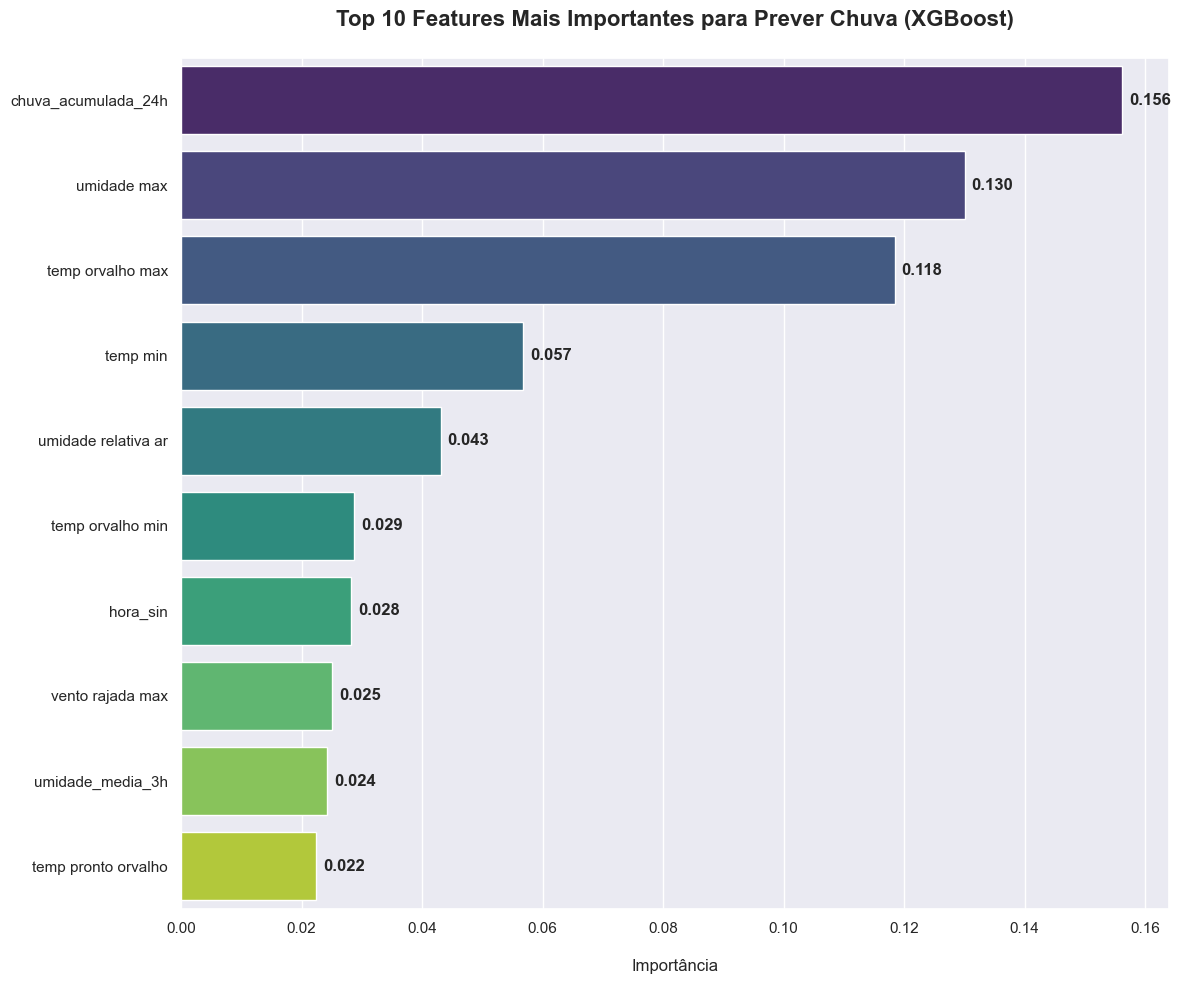

In [72]:
# --- Visualização ---
plt.figure(figsize=(12, 10))

ax = sns.barplot(x=importance.head(10),
            y=feature.head(10),
            palette="viridis")

for i, valor in enumerate(importance.head(10)):
    ax.annotate(f"{valor:.3f}",
                (valor, i),
                ha="left", va="center",
                xytext=(5, 0),
                textcoords="offset points",
                fontweight="bold")

plt.title('Top 10 Features Mais Importantes para Prever Chuva (XGBoost)\n', fontsize=16, fontweight='bold')
plt.xlabel('\nImportância', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.show()

As características climáticas que mais influenciam a previsão de chuva pelo modelo XGBoost pode ser muito bem apresentada através do gráfico.

A feature mais relevante é chuva_acumulada_24h (importância 0.156), seguida por umidade máxima e temperatura do orvalho máxima. Outras variáveis importantes incluem temperatura mínima, umidade relativa do ar, e indicadores derivados como hora_sin (representação cíclica da hora do dia) e média de umidade nas últimas 3 horas. Isso indica que o modelo utiliza tanto dados recentes de chuvas quanto padrões de umidade, temperatura e dinâmica temporal para compor suas previsões.

### Conclusão do Projeto

Este projeto teve como objetivo desenvolver um modelo eficiente para classificar se choveu ou não em Brasília, diante de dados horários com forte desbalanceamento entre as classes. Considerando a criticidade de identificar corretamente os eventos de chuva (classe minoritária), o foco principal foi otimizar o recall, ou seja, maximizar a detecção de chuvas reais.

A partir da comparação entre diferentes algoritmos como Regressão Logística, Random Forest, XGBoost e LightGBM, o modelo XGBoost demonstrou ser o mais equilibrado e robusto, apresentando alta capacidade de discriminação entre classes (evidenciada pelo maior valor médio de AUC), e mantendo um recall elevado com ganhos relevantes em precisão e F1-Score.

Além disso, a análise da matriz de confusão mostrou que o XGBoost minimiza os casos de chuva não detectada (falsos negativos), fator essencial para aplicações ligadas à previsão meteorológica, enquanto evita falsos alarmes em nível controlado (falso positivo). A importância das variáveis indicou que o modelo captura bem as dependências climáticas críticas, como umidade máxima e temperatura do orvalho, agregando valor interpretativo que pode suportar decisões futuras.

Portanto, o XGBoost se destacou como a melhor escolha para este contexto, oferecendo um modelo preditivo confiável, eficiente e interpretável para alertar sobre precipitações em Brasília, com potencial para ser integrado a sistemas de monitoramento climático e apoiar medidas preventivas.